#### 背景说明
当出现雨、雪、雾霾等恶劣天气时，电流在对流层传播时一部分能量会被雨、雪、雾霾等吸收或散射，进而导致一部分能量被损耗，信号传递出现产生影响。对天气进行实时图像监测，对特殊天气进行精确分类，可适时采用增大功率或降低编码等方式降低影响。由于特殊天气数据存在样本量少、数据不平衡的问题，运用生成对抗网络进行天气图像生成，以解决上述问题。

#### 示例数据
本项目选取220张不同天气状况下的云层图片，利用深度卷积对抗网络（DCGAN）生成虚假的云层图片。

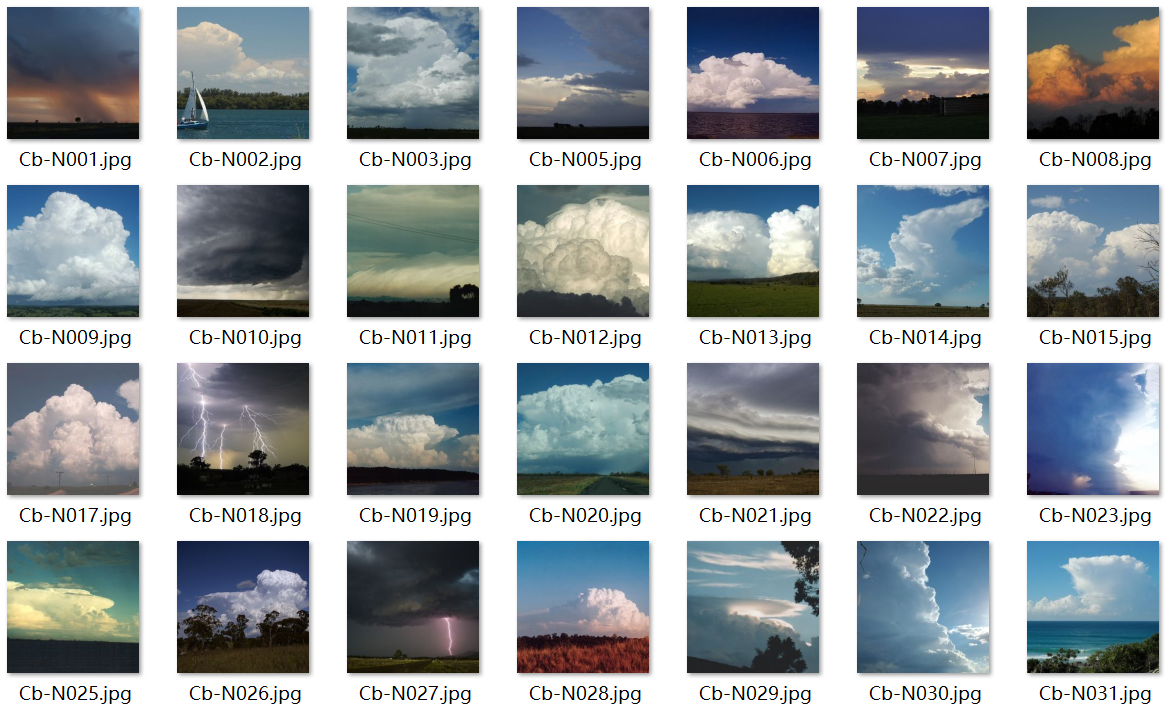

#### 分析思路
DCGAN是使用卷积网络的对抗网络，原理和GAN一样，只是把CNN卷积技术用于GAN模式的网络里。其主要包含两部分：生成器（G）和判别器（D），生成器使用反卷积伪造虚假图像，判别器用卷积识别图像。<br>
1.数据准备。读取文件夹中的云层图片，设置训练批次。<br>
2.搭建生成器。利用随机噪声通过反卷积伪造虚假天气图像。<br>
3.搭建判别器。判断图像是否为真，即假图像是否可以‘骗过’判别器。<br>
4.搭建生成对抗网络。进行生成对抗。
5.可视化评估。将生成的图像以gif图形式可视化。


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2023-02-21 13:25:22.256399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 13:25:22.256424: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1.数据准备

In [2]:
# 文件路径
data_dir = './data/'

In [3]:
# 读取数据集
cloud = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(64, 64),
    shuffle=False
)

Found 222 files belonging to 1 classes.


2023-02-21 13:25:23.965567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-21 13:25:23.965604: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 13:25:23.965628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iZ8vbgn1xqzjx291l2x9f6Z): /proc/driver/nvidia/version does not exist
2023-02-21 13:25:23.966030: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# 预先设置参数

# 设置batch和图片大小
batch_size = 32
img_height = 64
img_width = 64
img_depth = 3

# 批次大小
steps_per_epoch = len(cloud)

# 设置图片像素（64*64*3）
img_pixels = 64 * 64 * 3

# 维度
latent_dim = 64

# 训练轮次
epochs = 50

# 绘图大小
rows = 5
cols = 5

## 2.搭建生成器

In [5]:
# 随机生成正态噪声，用于生成图片
fixed_noise = tf.random.normal(shape = (batch_size, latent_dim))

考点一：全连接层，反卷积层<br>
考点二：步长，填充<br>
考点三：重塑尺寸，批归一化层<br>
考点四：配置训练方法<br>

In [6]:
# 生成器
def build_generator():
    # 搭建网络
    generator = tf.keras.Sequential()

    # 设置图像分辨率
    square_dim = 4
      
    # 全连接层
    generator.add(tf.keras.layers.Dense(square_dim * square_dim * 256, kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.02), input_dim = latent_dim))
    # 激活函数LeakyReLU
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    # 批归一化
    generator.add(tf.keras.layers.BatchNormalization())
    # 调整输出尺寸
    generator.add(tf.keras.layers.Reshape(target_shape = (square_dim, square_dim, 256)))
    
    # 反卷积层（2D），滤波器为128，窗口大小（4,4），步长为2，填充，激活函数为selu
    generator.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same', activation = 'selu', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.02)))
    # 批归一化
    generator.add(tf.keras.layers.BatchNormalization())
    
    # 反卷积层（2D），滤波器为64，窗口大小（4,4），步长为2，填充，激活函数为selu
    generator.add(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides = 2, padding = 'same', activation = 'selu', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.02)))
    # 批归一化
    generator.add(tf.keras.layers.BatchNormalization())
    
    # 反卷积层（2D），滤波器为32，窗口大小（4,4），步长为2，填充，激活函数为selu
    generator.add(tf.keras.layers.Conv2DTranspose(32, (4, 4), strides = 2, padding = 'same', activation = 'selu', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.02)))
    # 批归一化
    generator.add(tf.keras.layers.BatchNormalization())
    
    # 反卷积层（2D），滤波器为3，窗口大小（4,4），步长为2，填充，激活函数为tanh
    generator.add(tf.keras.layers.Conv2DTranspose(3, (4, 4), strides = 2, activation = 'tanh', padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.02)))
    # 配置训练方法，损失函数设置为二分类交叉熵，优化器设置为rmsprop
    generator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

    return generator

## 3.搭建判别器

考点五：卷积层，dropout层,激活函数

In [7]:
# 判别器
def build_discriminator():
    # 搭建网络
    discriminator = tf.keras.Sequential()
    
    # 2D卷积层，滤波器为32，窗口大小（4,4），步长为2，填充
    discriminator.add(tf.keras.layers.Conv2D(32, (4, 4), strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.002), input_shape = (64, 64, 3)))
    # 激活函数LeakyReLU
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    # 丢弃40%神经元
    discriminator.add(tf.keras.layers.Dropout(0.4))
    
    # 2D卷积层，滤波器为64，窗口大小（4,4），步长为2，填充
    discriminator.add(tf.keras.layers.Conv2D(64, (4, 4), strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.002)))
    # 激活函数LeakyReLU
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    # 丢弃40%神经元
    discriminator.add(tf.keras.layers.Dropout(0.4))
    
    # 2D卷积层，滤波器为128，窗口大小（4,4），步长为2，填充
    discriminator.add(tf.keras.layers.Conv2D(128, (4, 4), strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.002)))
    # 激活函数LeakyReLU
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    # 丢弃40%神经元
    discriminator.add(tf.keras.layers.Dropout(0.4))
    
    # 2D卷积层，滤波器为256，窗口大小（4,4），步长为2，填充
    discriminator.add(tf.keras.layers.Conv2D(256, (4, 4), strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.002)))
    # 激活函数LeakyReLU
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    # 丢弃40%神经元
    discriminator.add(tf.keras.layers.Dropout(0.4))
    
    # 平铺层
    discriminator.add(tf.keras.layers.Flatten())
    # 全连接层，设置激活函数，做二分类
    discriminator.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    # 配置训练方法，损失函数设置为二分类交叉熵，优化器设置为rmsprop
    discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

    return discriminator

考点六：tf数据类型转化

In [8]:
def save_images(epoch):
    # 假图像
    fake_imgs = generator.predict(fixed_noise)
    # 0~1转换为0~255的RGB颜色
    fake_imgs = (fake_imgs * 127.5) + 127.5  
    # 绘制多子图图像
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (6,6))
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            # 转换类型为tf.int32
            img_disp = tf.cast(fake_imgs[index], tf.int32)
            # 展示图像
            ax[i, j].imshow(img_disp)
            # 移除坐标轴
            ax[i, j].axis('off')
    # 保存图像
    plt.savefig('./img/Epoch{:04d}.png'.format(epoch))

## 4.搭建生成对抗网络

考点七：精细管理训练，以及（）内需要填充的内容

In [9]:
def train_gan(epochs):
    for epoch in range(epochs):
        
        # 迭代器实现迭代所有批次
        iterator = iter(cloud)
        
        for step in range(steps_per_epoch - 1): 
            # 随机生成正态噪声信息
            noise = tf.random.normal(shape = (batch_size, latent_dim))
            # 假图像
            fake_imgs = generator.predict(noise)
            # 从iterator里取出一个元素
            real_imgs = iterator.get_next()
            # 0~255的RGB颜色转换为0~1
            real_imgs = (real_imgs - 127.5) / 127.5
            # 设置真假图像标签
            discriminator_zeros = tf.zeros(shape = (batch_size, 1)) # 创建元素均为0的张量
            discriminator_ones = tf.ones(shape = (batch_size, 1)) # 创建元素均为1的张量
            # 训练并计算判别器损失
            discriminator_loss_real = discriminator.train_on_batch(real_imgs, discriminator_ones) # 真实图像（精细管理训练），（输入，标签）
            discriminator_loss_fake = discriminator.train_on_batch(fake_imgs, discriminator_zeros) # 虚假图像（精细管理训练），（输入，标签）
            # 判别器损失
            discriminator_loss = 0.5 * (discriminator_loss_real + discriminator_loss_fake)
            # 训练生成器 
            g_y = tf.ones(shape = (batch_size, 1)) # 创建元素均为1的张量
            g_loss = dcgan.train_on_batch(noise, g_y) # 精细管理训练，（输入，标签）
            
        print(f'Epoch: {epoch},    Driscriminator Loss: {discriminator_loss},    DCGAN Loss: {g_loss}')
        
        if epoch % 10 == 0:
            save_images(epoch)

考点八：冻结层<br>
考点九：输入数据<br>
考点十：搭建模型

In [10]:
# 生成器
generator = build_generator()
# 判别器
discriminator = build_discriminator()
# 冻结判别器
discriminator.trainable = False
# 输入数据（实例化 Keras 张量）
gan_input = tf.keras.layers.Input(shape = (latent_dim,))
# 生成图片
generated_imgs = generator(gan_input)
# 判别图片
gan_output = discriminator(generated_imgs)
# 搭建模型，指定输入和输出
dcgan = tf.keras.Model(gan_input, gan_output)
# 配置训练方法，损失函数设置为二分类交叉熵，优化器设置为rmsprop
dcgan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

2023-02-21 13:25:24.420444: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch: 0,    Driscriminator Loss: 0.390692587941885,    DCGAN Loss: 0.20456844568252563
Epoch: 1,    Driscriminator Loss: 0.6808909177780151,    DCGAN Loss: 0.83857262134552
Epoch: 2,    Driscriminator Loss: 0.7448649704456329,    DCGAN Loss: 0.765553891658783
Epoch: 3,    Driscriminator Loss: 0.6812405586242676,    DCGAN Loss: 0.7577669620513916
Epoch: 4,    Driscriminator Loss: 0.7055006325244904,    DCGAN Loss: 0.48655951023101807
Epoch: 5,    Driscriminator Loss: 0.3355964571237564,    DCGAN Loss: 0.08047045767307281
Epoch: 6,    Driscriminator Loss: 0.1198887750506401,    DCGAN Loss: 0.1263074278831482
Epoch: 7,    Driscriminator Loss: 0.0437431326135993,    DCGAN Loss: 0.0009517704020254314
Epoch: 8,    Driscriminator Loss: 0.04077564552426338,    DCGAN Loss: 0.011653757654130459
Epoch: 9,    Driscriminator Loss: 0.15020176023244858,    DCGAN Loss: 0.11185616999864578
Epoch: 10,    Driscriminator Loss: 0.3828372061252594,    DCGAN Loss: 0.08411548286676407
Epoch: 11,    Driscrimi

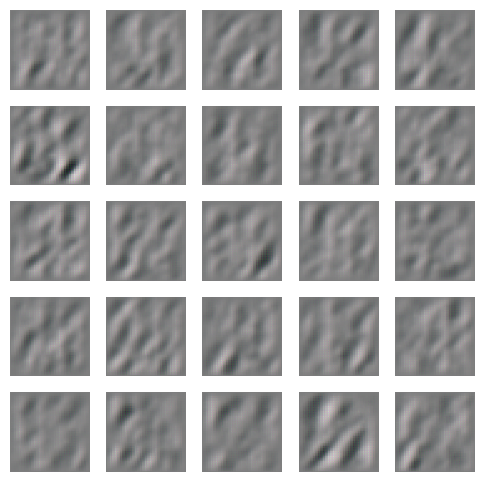

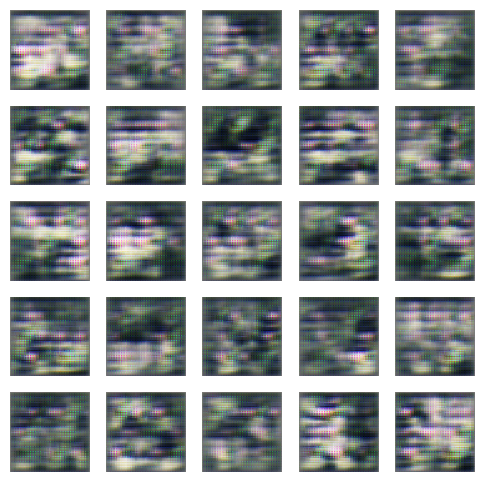

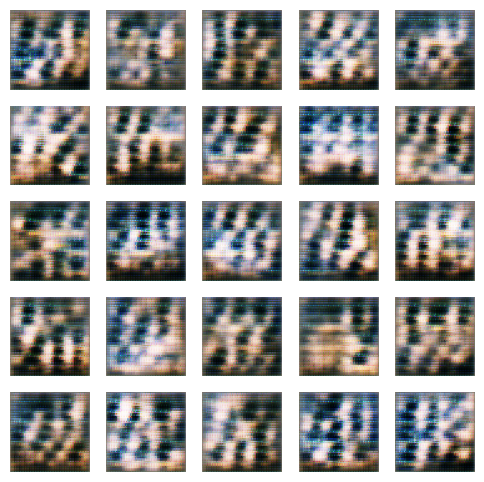

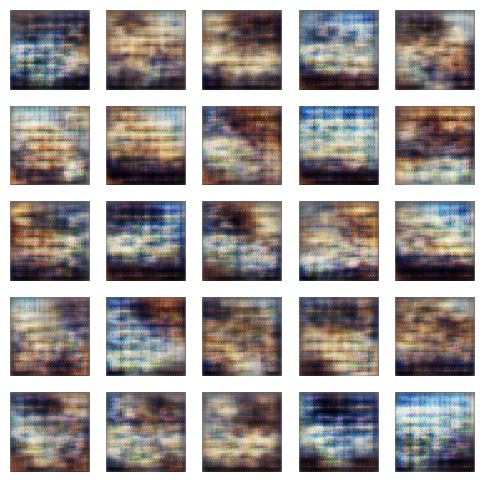

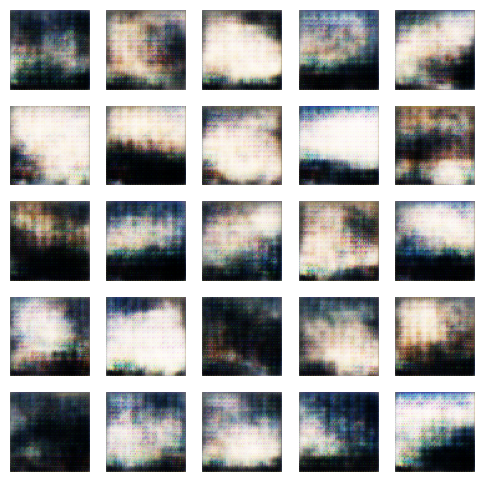

In [11]:
train_gan(epochs)

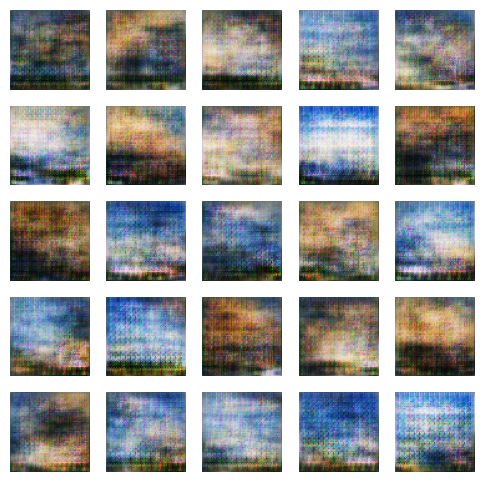

In [12]:
# 保存图像
save_images(epochs) 

## 5.可视化评估

In [13]:
# 建立gif图
import imageio
import glob
filepath = 'dcgan.gif'

with imageio.get_writer(filepath, mode='I') as writer:
    # glob读取所有图片路径
    filenames = glob.glob('./img/Epoch*.png')
    # 按照图片名称排序
    filenames = sorted(filenames)
    # for循环读取
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

考点十一：存储模型

In [14]:
# 保存模型
# 保存判别器
discriminator.save('dcgan_discriminator.h5')
# 保存生成器
generator.save('dcgan_generator.h5')